In [4]:
import pandas as pd
import numpy as np

import datetime 
import time

from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.utils import shuffle


In [5]:
!unzip -n archive.zip

Archive:  archive.zip


Considering the order of rating preference for an user being defined in the order of viewing-->addtocart and then transaction

Log scale signifies that 10 number of views is equivalent to 1 instance of addting to cart
Same analogy can be applied to cart:transaction

We can keep duplicates of users and items and describe preference order as 1,2 and 3 for viewing, adding and transaction but then tis orinality will make less sense.

Else we can play with these values


In [ ]:
from google.colab import files
uploaded = files.upload()

In [7]:
events_df = pd.read_csv('./events.csv')

events_df.head()
events_df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [8]:
events_df = pd.read_csv('./events.csv')

events_df.head()
# events_df.shape


events_df.event.value_counts()
# events_df.nunique()
#buying as 3,add_to_cart=2,view=1



# events_df.dropna(inplace=True)
events_df['event_encode']=events_df['event'].map({
    'view':0.1,'addtocart':1,'transaction':10
})
# events_df.drop_duplicates(subset=
                          # ['visitorid','itemid']).shape[0]/events_df.shape[0]

df_events=events_df.groupby(['visitorid','itemid'])['event_encode'].sum().to_frame('rating').reset_index()

In [17]:
df_events.describe().round()

# df_events.

,visitorid,itemid,rating
count,2145179.0,2145179.0,2145179.0
mean,702031.0,234614.0,0.0
std,405680.0,134116.0,1.0
min,0.0,3.0,0.0
25%,350566.0,117673.0,0.0
50%,702113.0,235401.0,0.0
75%,1052906.0,350399.0,0.0
max,1407579.0,466867.0,142.0


In [18]:
# df_events.rating.value_counts().astype(float).plot(kind='hist',bins=20)

In [25]:
df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,1,10,1000],right=False,
                      labels=[1,2,3],
                      include_lowest=True)
#Views,addt0cart,transaction

df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,0.2,1,10,1000],right=False,
                      labels=[1,2,3,4],
                      include_lowest=True)
df_events.cum_rating.value_counts()
df_events.loc[:,'cum_rating']=df_events.loc[:,'cum_rating'].astype(int)
#just_views,higher_views,addt0cart,transaction

In [26]:
df_events.cum_rating.value_counts()


2    277000
1    180179
3     45071
4     21315
Name: cum_rating, dtype: int64

In [21]:
df_events=pd.concat([df_events[df_events.cum_rating==1].sample(int(0.1*df_events[df_events.cum_rating==1].shape[0])),
                     df_events[df_events.cum_rating!=1]])
df_events.cum_rating.value_counts()


2    277000
1    180179
3     45071
4     21315
Name: cum_rating, dtype: int64

Need to have zero start and continuous,increment by 1
items and users ids do as to formulate embedder matrix

In [27]:
df_events.columns

df_events.visitorid = pd.Categorical(df_events.visitorid)
df_events['new_vis_id'] = df_events.visitorid.cat.codes

df_events.itemid = pd.Categorical(df_events.itemid)
df_events['new_item_id'] = df_events.itemid.cat.codes

In [31]:
df_events.head()

,visitorid,itemid,rating,cum_rating,new_vis_id,new_item_id
58485,38917,242569,0.1,1,10524,62396
1457367,953096,10934,0.1,1,256841,2779
571545,372492,162111,0.1,1,100436,41680
620831,404916,296795,0.1,1,109160,76406
1762196,1151791,380400,0.1,1,310540,97896


In [32]:
df_events.describe()
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df_events['new_vis_id'].values
item_ids = df_events['new_item_id'].values
ratings = df_events['cum_rating'].values

In [33]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(item_ids))

# Set embedding dimension
K = 10
N,M

(379310, 120053)

In [34]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)#because of definition of embedder matrix

#Architecture of the model
# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)


# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# split the data
#will create hold out set later, need to devise a way
user_ids, item_ids, ratings = shuffle(user_ids, item_ids, ratings)
Ntrain = int(0.85 * len(ratings))

train_user = user_ids[:Ntrain]
train_item = item_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_item = item_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# # center the ratings
# avg_rating = train_ratings.mean()
# train_ratings = train_ratings - avg_rating
# test_ratings = test_ratings - avg_rating

In [35]:
pow(0.6,1/2)

0.7745966692414834

In [ ]:
r = model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_ratings], test_ratings),
)

Epoch 1/25
435/435 - 3s - loss: 0.5852 - val_loss: 0.5635
Epoch 2/25
435/435 - 2s - loss: 0.5623 - val_loss: 0.5640
Epoch 3/25
435/435 - 2s - loss: 0.5620 - val_loss: 0.5629
Epoch 4/25
435/435 - 2s - loss: 0.5610 - val_loss: 0.5590
Epoch 5/25
435/435 - 2s - loss: 0.5494 - val_loss: 0.5450
Epoch 6/25
435/435 - 2s - loss: 0.5368 - val_loss: 0.5350
Epoch 7/25
435/435 - 2s - loss: 0.5245 - val_loss: 0.5283
Epoch 8/25
435/435 - 2s - loss: 0.5068 - val_loss: 0.5320
Epoch 9/25
435/435 - 2s - loss: 0.4871 - val_loss: 0.5390
Epoch 10/25
435/435 - 2s - loss: 0.4646 - val_loss: 0.5605
Epoch 11/25
435/435 - 2s - loss: 0.4429 - val_loss: 0.5997
Epoch 12/25
435/435 - 2s - loss: 0.4197 - val_loss: 0.5984
Epoch 13/25
435/435 - 2s - loss: 0.3967 - val_loss: 0.6359
Epoch 14/25
435/435 - 2s - loss: 0.3725 - val_loss: 0.7437
Epoch 15/25
435/435 - 2s - loss: 0.3479 - val_loss: 0.8038
Epoch 16/25
435/435 - 2s - loss: 0.3232 - val_loss: 0.8680
Epoch 17/25
435/435 - 2s - loss: 0.2983 - val_loss: 0.9967
Epoch 

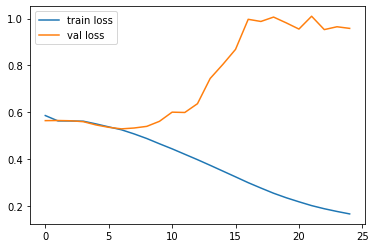

In [ ]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

With lerger training data

Epoch 1/25
323/323 - 1s - loss: 0.1762 - val_loss: 0.3097
Epoch 2/25
323/323 - 1s - loss: 0.1637 - val_loss: 0.2980
Epoch 3/25
323/323 - 1s - loss: 0.1527 - val_loss: 0.3079
Epoch 4/25
323/323 - 1s - loss: 0.1429 - val_loss: 0.3079
Epoch 5/25
323/323 - 1s - loss: 0.1348 - val_loss: 0.3247
Epoch 6/25
323/323 - 1s - loss: 0.1261 - val_loss: 0.3202
Epoch 7/25
323/323 - 1s - loss: 0.1186 - val_loss: 0.3197
Epoch 8/25
323/323 - 1s - loss: 0.1095 - val_loss: 0.3209
Epoch 9/25
323/323 - 1s - loss: 0.1008 - val_loss: 0.3324
Epoch 10/25
323/323 - 1s - loss: 0.0943 - val_loss: 0.3334
Epoch 11/25
323/323 - 1s - loss: 0.0871 - val_loss: 0.3321
Epoch 12/25
323/323 - 1s - loss: 0.0823 - val_loss: 0.3306
Epoch 13/25
323/323 - 1s - loss: 0.0764 - val_loss: 0.3439
Epoch 14/25
323/323 - 1s - loss: 0.0710 - val_loss: 0.3609
Epoch 15/25
323/323 - 1s - loss: 0.0692 - val_loss: 0.3376
Epoch 16/25
323/323 - 1s - loss: 0.0637 - val_loss: 0.3395
Epoch 17/25
323/323 - 1s - loss: 0.0604 - val_loss: 0.3460
Epoch 

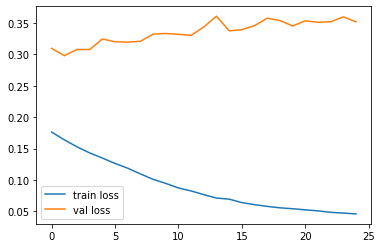

In [ ]:
ii=0.5
df_events=pd.concat([df_events[df_events.cum_rating==1].sample(int(ii*df_events[df_events.cum_rating==1].shape[0])),
                     df_events[df_events.cum_rating!=1]])
df_events.cum_rating.value_counts()


df_events.visitorid = pd.Categorical(df_events.visitorid)
df_events['new_vis_id'] = df_events.visitorid.cat.codes

df_events.itemid = pd.Categorical(df_events.itemid)
df_events['new_item_id'] = df_events.itemid.cat.codes



user_ids = df_events['new_vis_id'].values
item_ids = df_events['new_item_id'].values
ratings = df_events['cum_rating'].values


# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(item_ids))
# Set embedding dimension
K = 10



df_train,df_test=train_test_split(df_events,shuffle=True,test_size=0.15,
                                  stratify=df_events['cum_rating'].astype(str))

train_user = df_train['new_vis_id'].values
train_item = df_train['new_item_id'].values
train_ratings = df_train['cum_rating'].values

test_user = df_test['new_vis_id'].values
test_item = df_test['new_item_id'].values
test_ratings = df_test['cum_rating'].values

# # center the ratings
# avg_rating = train_ratings.mean()
# train_ratings = train_ratings - avg_rating
# test_ratings = test_ratings - avg_rating


r = model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, 
  validation_data=([test_user, test_ratings], test_ratings),
)



# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

Epoch 1/25
319/319 - 1s - loss: 0.0772 - val_loss: 0.2704
Epoch 2/25
319/319 - 1s - loss: 0.0719 - val_loss: 0.2716
Epoch 3/25
319/319 - 1s - loss: 0.0660 - val_loss: 0.2664
Epoch 4/25
319/319 - 1s - loss: 0.0630 - val_loss: 0.2814
Epoch 5/25
319/319 - 1s - loss: 0.0579 - val_loss: 0.2776
Epoch 6/25
319/319 - 1s - loss: 0.0543 - val_loss: 0.2813
Epoch 7/25
319/319 - 1s - loss: 0.0513 - val_loss: 0.2772
Epoch 8/25
319/319 - 1s - loss: 0.0483 - val_loss: 0.2856
Epoch 9/25
319/319 - 1s - loss: 0.0468 - val_loss: 0.2752
Epoch 10/25
319/319 - 1s - loss: 0.0457 - val_loss: 0.2862
Epoch 11/25
319/319 - 1s - loss: 0.0428 - val_loss: 0.2851
Epoch 12/25
319/319 - 1s - loss: 0.0421 - val_loss: 0.2839
Epoch 13/25
319/319 - 1s - loss: 0.0401 - val_loss: 0.2761
Epoch 14/25
319/319 - 1s - loss: 0.0389 - val_loss: 0.2899
Epoch 15/25
319/319 - 1s - loss: 0.0371 - val_loss: 0.2788
Epoch 16/25
319/319 - 1s - loss: 0.0363 - val_loss: 0.2798
Epoch 17/25
319/319 - 1s - loss: 0.0356 - val_loss: 0.2774
Epoch 

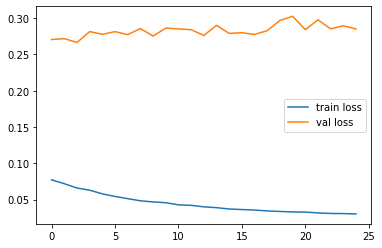

In [ ]:
ii=0.9
df_events=pd.concat([df_events[df_events.cum_rating==1].sample(int(ii*df_events[df_events.cum_rating==1].shape[0])),
                     df_events[df_events.cum_rating!=1]])
df_events.cum_rating.value_counts()


df_events.visitorid = pd.Categorical(df_events.visitorid)
df_events['new_vis_id'] = df_events.visitorid.cat.codes

df_events.itemid = pd.Categorical(df_events.itemid)
df_events['new_item_id'] = df_events.itemid.cat.codes



user_ids = df_events['new_vis_id'].values
item_ids = df_events['new_item_id'].values
ratings = df_events['cum_rating'].values


# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(item_ids))
# Set embedding dimension
K = 10



df_train,df_test=train_test_split(df_events,shuffle=True,test_size=0.15,
                                  stratify=df_events['cum_rating'].astype(str))

train_user = df_train['new_vis_id'].values
train_item = df_train['new_item_id'].values
train_ratings = df_train['cum_rating'].values

test_user = df_test['new_vis_id'].values
test_item = df_test['new_item_id'].values
test_ratings = df_test['cum_rating'].values

# # center the ratings
# avg_rating = train_ratings.mean()
# train_ratings = train_ratings - avg_rating
# test_ratings = test_ratings - avg_rating


r = model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, 
  validation_data=([test_user, test_ratings], test_ratings),
)



# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()